Perceptron-----------------------------
accuracy (train):  0.95
accuracy (test):  0.97
Support Vector Machine ---------------------
accuracy (train):  0.92
accuracy (test):  0.91
accuracy (train):  0.92
accuracy (test):  0.91
Number of supprt vectors: 66
-----------------
accuracy (train):  0.44
accuracy (test):  0.65
accuracy (train):  0.62
accuracy (test):  0.24


D:\6m_NIC\Quantum codes\new-venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


accuracy (train):  0.65
accuracy (test):  0.29
QBoost -------------------------------------
accuracy (train):  0.65
accuracy (test):  0.29
QAOA -----------------------------


ModuleNotFoundError: No module named 'pyquil'

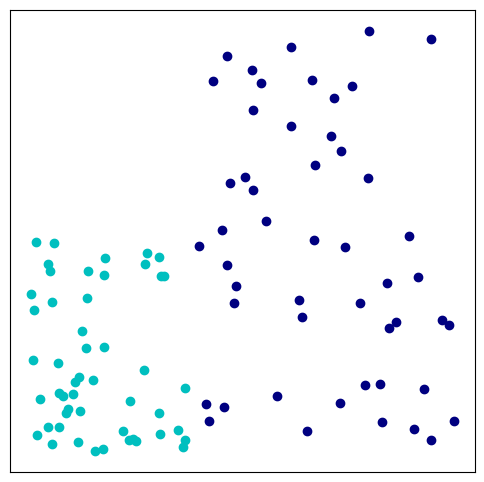

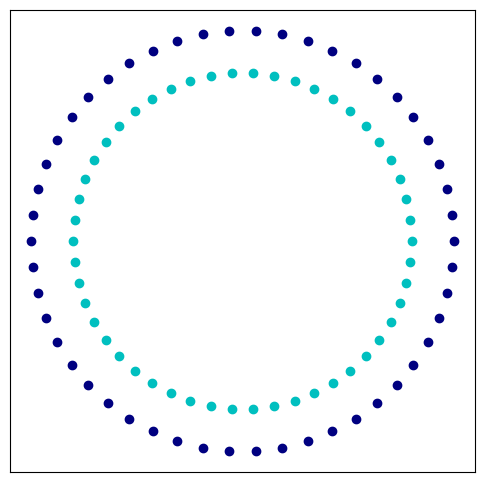

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.metrics
import sklearn.datasets

# Loss Functions and Regularization

# Create easy scenario with data pts split into two that are distinguishable 

c1 = np.random.rand(50, 2)/5
c2 = (-0.6, 0.5) * np.random.rand(50, 2)/5
data = np.concatenate((c1, c2))
labels = np.array([0] * 50 + [1] * 50)
plt.figure(figsize=(6, 6))
plt.subplot(111, xticks=[], yticks=[])
plt.scatter(data[:50, 0], data[:50, 1], color='navy')
plt.scatter(data[50:, 0], data[50:, 1], color='c')
#plt.show()

# Shuffle data into training set and a test set (2/3 to 1/3 ratio)
idx = np.arange(len(labels))
np.random.shuffle(idx)
idx_train = idx[:2*len(idx)//3]
idx_test = idx[2*len(idx)//3:]
X_train = data[idx_train]
X_test = data[idx_test]
y_train = labels[idx_train]
y_test = labels[idx_test]

metric = sklearn.metrics.accuracy_score

# Train Perceptron 
# Linear Loss func 1/N * sum_(i=1 to N) |h(x_i) - y_i|
print('Perceptron-----------------------------')
from sklearn.linear_model import Perceptron
model_1 = Perceptron()
model_1.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_1.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_1.predict(X_test))))

# Now try a support vector machine
# C hyperparameter controls a regularization term that penalizes the objective for the number of support vectors
print('Support Vector Machine ---------------------')
from sklearn.svm import SVC
model_2 = SVC(kernel='linear', C=1)
model_2.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_2.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_2.predict(X_test))))

model_2 = SVC(kernel='linear', C=0.01)
model_2.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_2.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_2.predict(X_test))))
print('Number of supprt vectors:', sum(model_2.n_support_))


# Ensemble Methods --------------------------------------
# Strategic combination of classifiers can reduce total error improving generalization

# Develop a set of base classifiers from the training data.
# Comebine them to form ensemble.

metric = sklearn.metrics.accuracy_score

# Generate random dataset of two classes to form concentric circles
np.random.seed(0)
data, labels = sklearn.datasets.make_circles()
idx = np.arange(len(labels))
np.random.shuffle(idx)
# train on 2/3 and tes ton 1/3
idx_train = idx[:2*len(idx)//3]
idx_test = idx[2*len(idx)//3:]
X_train = data[idx_train]
X_test = data[idx_test]

y_train = 2 * labels[idx_train] - 1  # binary -> spin
y_test = 2 * labels[idx_test] - 1

scaler = sklearn.preprocessing.StandardScaler()
normalizer = sklearn.preprocessing.Normalizer()

X_train = scaler.fit_transform(X_train)
X_train = normalizer.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)
X_test = normalizer.fit_transform(X_test)

plt.figure(figsize=(6, 6))
plt.subplot(111, xticks=[], yticks=[])
plt.scatter(data[labels == 0, 0], data[labels == 0, 1], color='navy')
plt.scatter(data[labels == 1, 0], data[labels == 1, 1], color='c')

#plt.show()
print('-----------------')
# Train perceptron 
model_1 = Perceptron()
model_1.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_1.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_1.predict(X_test))))

# SVC with non linear kernel
model_2 = SVC(kernel='rbf')
model_2.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_2.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_2.predict(X_test))))


# Boosting is an ensemble method that seeks models that complement one another.
# Variation between boosting algorithms is how they combine weak learners.
# AdaBoost is popular , it combines weak learners in a sequential manner based on individual accuracies.
# There is a convex objective function that does not penalize for complexity.

from sklearn.ensemble import AdaBoostClassifier
model_3 = AdaBoostClassifier(n_estimators=3)
model_3.fit(X_train, y_train)
print('accuracy (train): %5.2f'%(metric(y_train, model_3.predict(X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, model_3.predict(X_test))))

# Q Boost 

"""
The following problem is solved through a rephrased objective:

argmin_w 1/N * sum_(i=N) (sum_(k=1 to K) w_k*h_k(x_i) - y_i)^2 + lambda||w||_0 


"""

# Consider the models from above as weak leaners

models = [model_1, model_2, model_3]

# Calculate predictions and set lambda to 1
# Predictions scaled to reflect averaging in objective

n_models = len(models)

predictions = np.array([h.predict(X_train) for h in models], dtype=np.float64)
# scale hij to [-1/N , 1/N]
predictions *= 1/n_models

lamb = 1


print('QBoost -------------------------------------')
# Create Quadratic Binary Optimization of objective function as expanded above

w = np.dot(predictions, predictions.T)
wii = len(X_train) / (n_models ** 2) + lamb - 2 * np.dot(predictions, y_train)
w[np.diag_indices_from(w)] = wii
W = {}
for i in range(n_models):
    for j in range(i, n_models):
        W[(i, j)] = w[i, j]


# Solve QUBO with simulated annealing and get optimal weights
import dimod
sampler = dimod.SimulatedAnnealingSampler()
response = sampler.sample_qubo(W, num_reads=10)
weights = list(response.first.sample.values())

# Prediction method to help with measuring accuracy
def predict(models, weights, X):
    n_data = len(X)
    T = 0
    y = np.zeros(n_data)
    for i, h in enumerate(models):
        y0 = weights[i] * h.predict(X) # prediction of weak classifier
        y += y0
        T += np.sum(y0)

    y = np.sign(y - T / (n_data*len(models)))

    return y

print('accuracy (train): %5.2f'%(metric(y_train, predict(models, weights, X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, predict(models, weights, X_test))))

# Accuracy co-incides with strongest weak learners, AdaBoost.

print('QAOA -----------------------------')
# Solve with QAOA

# Map the QUBO to a Ising model
h, J, offset = dimod.qubo_to_ising(W)

from pyquil import Program, api
from pyquil.paulis import PauliSum, PauliTerm
from scipy.optimize import fmin_bfgs
from grove.pyqaoa.qaoa import QAOA
from forest_tools import *
qvm = api.SyncConnection()

num_nodes = w.shape[0]
ising_model = []
for i in range(num_nodes):
    ising_model.append(PauliSum([PauliTerm("Z", i, h[i])]))
    for j in range(i+1, num_nodes):
        ising_model.append(PauliSum([PauliTerm("Z", i, J[i, j]) * PauliTerm("Z", j, 1.0)]))

# Run optimization
p = 1
Hm = [PauliSum([PauliTerm("X", i, 1.0)]) for i in range(num_nodes)]
qaoa = QAOA(qvm,
            qubits=range(num_nodes),
            steps=p,
            ref_ham=Hm,
            cost_ham=ising_model,
            store_basis=True,
            minimizer=fmin_bfgs,
            minimizer_kwargs={'maxiter': 50})

nu, gamma = qaoa.get_angles()
program = qaoa.get_parameterized_program()(np.hstack((nu, gamma)))
measures = qvm.run_and_measure(program, range(num_nodes), trials=100)
measures = np.array(measures)

hist = plt.hist([str(m) for m in measures])
#plt.show()

# Extract most likely solution
count = np.unique(measures, return_counts=True, axis=0)
weights = count[0][np.argmax(count[1])]

print('weights = ', weights)

print('accuracy (train): %5.2f'%(metric(y_train, predict(models, weights, X_train))))
print('accuracy (test): %5.2f'%(metric(y_test, predict(models, weights, X_test))))

In [2]:
pip install dimod


   ---------------------------------------- 0.0/5.2 MB ? eta -:--:--
   -- ------------------------------------- 0.3/5.2 MB ? eta -:--:--
   -------- ------------------------------- 1.0/5.2 MB 7.1 MB/s eta 0:00:01
   ---------------- ----------------------- 2.1/5.2 MB 4.0 MB/s eta 0:00:01
   ------------------------------ --------- 3.9/5.2 MB 5.7 MB/s eta 0:00:01
   ---------------------------------------- 5.2/5.2 MB 5.7 MB/s eta 0:00:00


In [3]:
pip install --no-cache-dir pyquil

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\DELL\\AppData\\Local\\Temp\\pip-install-ymfmh8he\\quil_f85ccaa2d3c64ad0acb92fcf44d3139c\\quil-rs\\src\\waveform\\snapshots\\quil_rs__waveform__templates__tests__DragGaussian__duration_0_0001_fwhm_1e-5_t0_0_0_anh_1000000_0_alpha_1_0_sample_rate_1000000_0_scale_1_0_phase_0_0_detuning_0_0___data.snap'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths

